In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
from dotenv import load_dotenv
import os

In [2]:
mode="simulate"
#mode="real"

NOTE: THE STATE |0> corresponds to z=+1; the state |1> corresponds to z=-1

In [3]:
load_dotenv()
ibm_token = os.getenv('IBM_TOKEN')
print(ibm_token)

831dd959d21e9151bce0ce49b0b2058f24e6fe738ea71e01b06020085fcb03ff135be2a7616d68ef25215ff34817e66101740136b9efbb81a1f7180446a0549b


In [4]:
def qubit_idx(i, j, n_cols):
    return i * n_cols + j

In [5]:
from qiskit.quantum_info import SparsePauliOp

def build_ising_pauli_list(J, h):
    """
    Build the Pauli list for a 2D grid Ising Hamiltonian using a numpy array and periodic boundaries.

    Args:
        J (np.ndarray): 2D numpy array of coupling constants (J values) between nearest neighbors.
        h (np.ndarray): 2D numpy array of external magnetic field strengths.

    Returns:
        SparsePauliOp: Ising Hamiltonian as a SparsePauliOp.
    """
    import numpy as np

    rows, cols = J.shape
    n_qubits = rows * cols
    pauli_list = []

    def qubit_idx(i, j, cols):
        return i * cols + j

    # Add interaction terms
    for i in range(rows):
        for j in range(cols):
            current_index = qubit_idx(i, j, cols)

            # Horizontal interaction (right neighbor)
            if j + 1 < cols:  # Include periodic boundary if required
                ni, nj = i, (j + 1) % cols
                neighbor_index = qubit_idx(ni, nj, cols)
                paulis = ["I"] * n_qubits
                paulis[current_index] = "Z"
                paulis[neighbor_index] = "Z"
                pauli_list.append(("".join(paulis), -J[i, j]))

            # Vertical interaction (bottom neighbor)
            if i + 1 < rows:  # Include periodic boundary if required
                ni, nj = (i + 1) % rows, j
                neighbor_index = qubit_idx(ni, nj, cols)
                paulis = ["I"] * n_qubits
                paulis[current_index] = "Z"
                paulis[neighbor_index] = "Z"
                pauli_list.append(("".join(paulis), -J[i, j]))

            # External field term
            paulis = ["I"] * n_qubits
            paulis[current_index] = "Z"
            pauli_list.append(("".join(paulis), -h[i, j]))

    # Convert to SparsePauliOp
    return SparsePauliOp.from_list(pauli_list)


In [6]:
# Define params
n_rows = 2
n_cols = 2
reps = 10

In [7]:
#h = 0.7  # Magnetic field
#h = np.random.rand(n_rows, n_cols)
h = np.load('h_5_5.npy') # qaoa be default has this as positive
#h=np.array([[-0.42900093,-0.34531477], [-0.1746655,-0.28350231]])

n_rows, n_cols = h.shape
J = np.full((n_rows, n_cols), 1.0)
start_time_1 = time.time()
ising_hamiltonian = build_ising_pauli_list(J, h)
end_time_1 = time.time()
h

array([[ 0.15550876, -0.76035533, -0.3806358 ,  0.15184563,  0.49019705],
       [ 0.39550892, -0.98493943,  0.24475845,  0.68676797,  0.19494899],
       [ 0.93472569, -0.11999959,  0.23030518, -0.69481846,  0.09710608],
       [ 0.2831923 ,  0.21903091, -0.03833993,  0.82518734, -0.12193583],
       [ 0.3041201 ,  0.70881764,  0.30876409,  0.46855228,  0.96475797]])

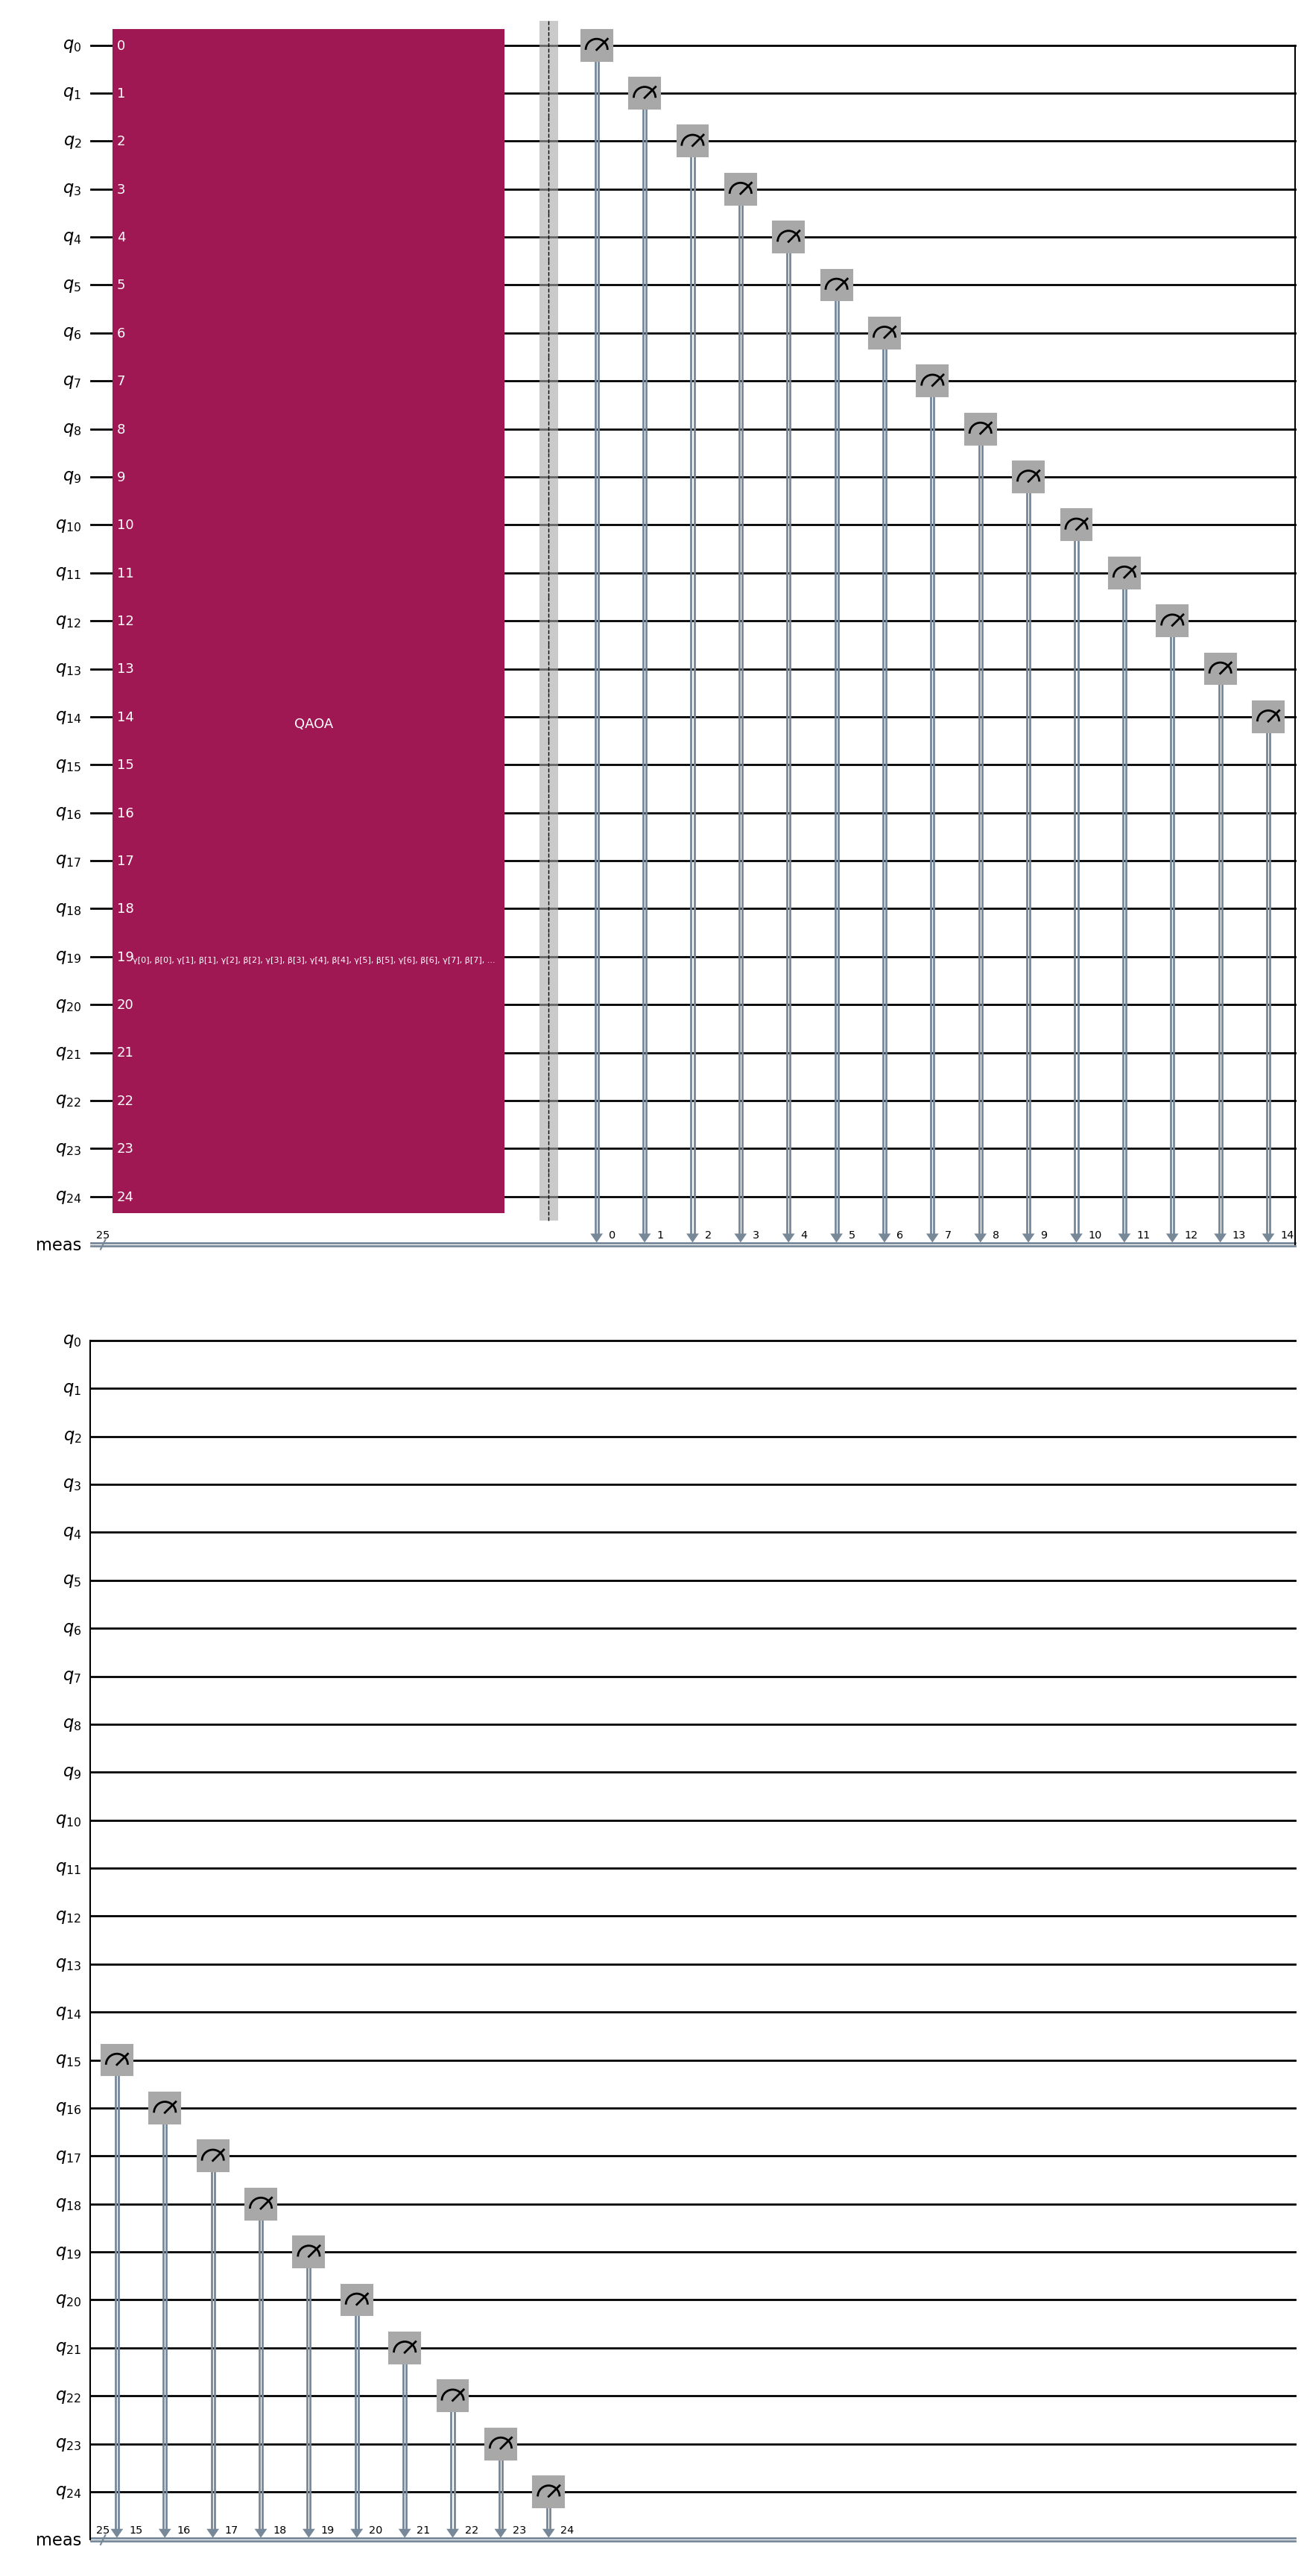

In [8]:
circuit = QAOAAnsatz(cost_operator=ising_hamiltonian, reps=reps)
circuit.measure_all()
circuit.draw('mpl')

In [9]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9])])

In [10]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True, set_as_default=True)

In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
simulator = AerSimulator()

In [12]:
if (mode == "simulate"):
    backend = simulator
else:
    service = QiskitRuntimeService(channel='ibm_quantum')
    backend = service.least_busy(min_num_qubits=127)


In [13]:
start_time_2 = time.time()
pm = generate_preset_pass_manager(optimization_level=3,backend=backend)
candidate_circuit = pm.run(circuit)
end_time_2 = time.time()
#candidate_circuit.draw('mpl', fold=False, idle_wires=False)


In [14]:
backend

AerSimulator('aer_simulator')

In [15]:
initial_gamma = np.pi
initial_beta = np.pi

init_params = []
for i in range(reps):
    init_params.append(initial_gamma)
    init_params.append(initial_beta)


In [16]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [17]:
start_time_3 = time.time()
objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, ising_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    end_time_3 = time.time()
    print(result)

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.8896819169338395
       x: [ 3.141e+00  4.147e+00 ...  3.138e+00  3.144e+00]
    nfev: 112
   maxcv: 0.0


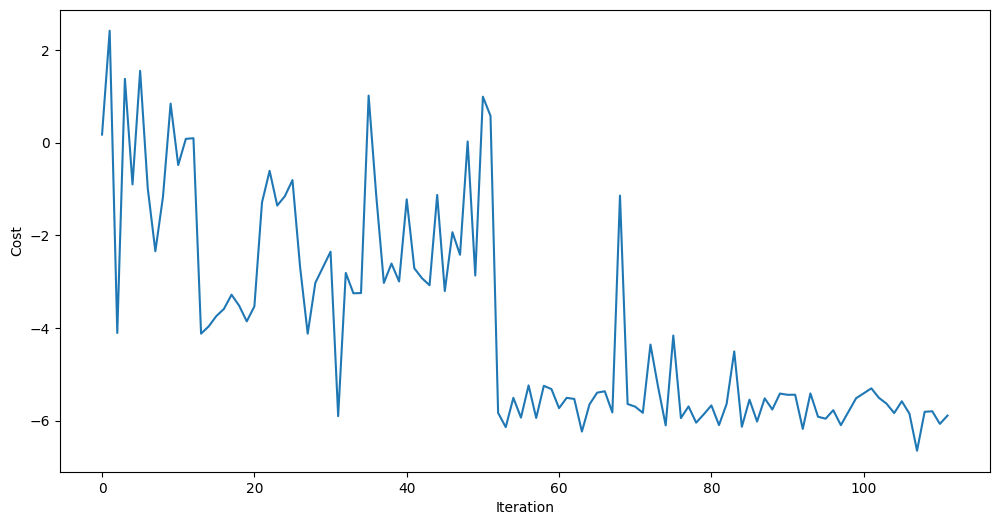

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [19]:
objective_func_vals

[array(0.17221886),
 array(2.41292207),
 array(-4.10788798),
 array(1.3753471),
 array(-0.90299328),
 array(1.54761703),
 array(-0.98521732),
 array(-2.34494568),
 array(-1.16890842),
 array(0.84011889),
 array(-0.48491484),
 array(0.07977996),
 array(0.09402798),
 array(-4.12263499),
 array(-3.96607771),
 array(-3.74386352),
 array(-3.58917345),
 array(-3.28215747),
 array(-3.51922553),
 array(-3.8572637),
 array(-3.53369363),
 array(-1.2914264),
 array(-0.61002316),
 array(-1.35828649),
 array(-1.15775373),
 array(-0.80971823),
 array(-2.68393246),
 array(-4.12352783),
 array(-3.02733855),
 array(-2.69059203),
 array(-2.35456719),
 array(-5.9024679),
 array(-2.81263845),
 array(-3.25136015),
 array(-3.24705154),
 array(1.01300765),
 array(-1.14715394),
 array(-3.02816145),
 array(-2.61027573),
 array(-2.99732804),
 array(-1.22489273),
 array(-2.71289622),
 array(-2.92570926),
 array(-3.07767731),
 array(-1.13037282),
 array(-3.20343666),
 array(-1.93417146),
 array(-2.42103783),
 arr

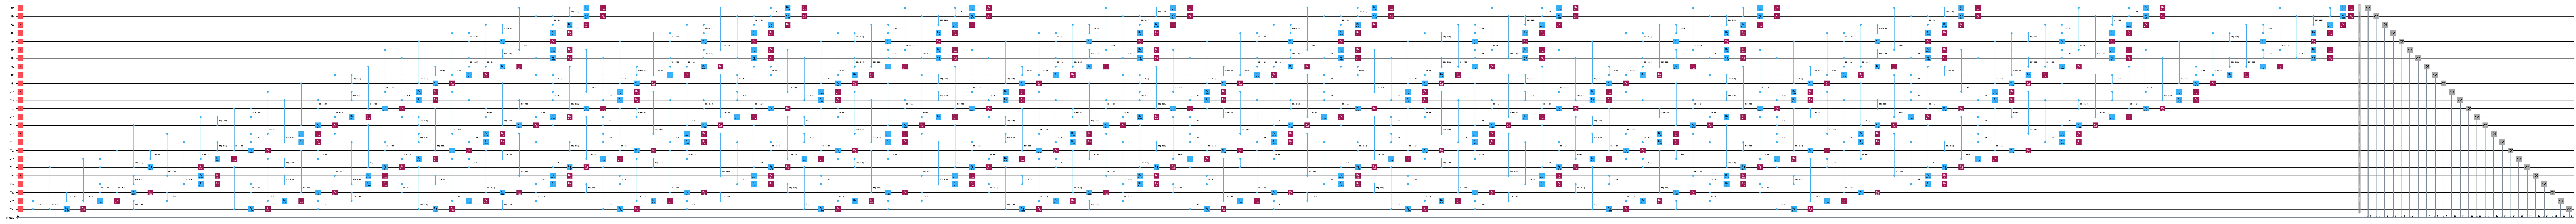

In [20]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [21]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
start_time = time.time()
job = sampler.run([pub], shots=int(1e4))
end_time = time.time()
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


{20317282: 0.0001, 17144835: 0.0001, 22709248: 0.0001, 33002891: 0.0001, 14131018: 0.0001, 6533898: 0.0001, 30774288: 0.0001, 23246107: 0.0001, 31753216: 0.0002, 31929538: 0.0001, 31956044: 0.0004, 20031752: 0.0001, 31827336: 0.0001, 27300940: 0.0001, 15565896: 0.0001, 23168784: 0.0001, 3556867: 0.0001, 23274504: 0.0001, 31528232: 0.0001, 23172360: 0.0003, 33293358: 0.0001, 6522060: 0.0001, 7832844: 0.0001, 19258186: 0.0001, 32503040: 0.0001, 18955528: 0.0001, 24872335: 0.0001, 29689160: 0.0001, 30906434: 0.0001, 19505160: 0.0001, 6622861: 0.0001, 30856768: 0.0001, 23692739: 0.0001, 23566776: 0.0001, 23171839: 0.0001, 33358862: 0.0001, 33002640: 0.0001, 24769600: 0.0001, 31786280: 0.0001, 28804096: 0.0001, 31888842: 0.0001, 30382344: 0.0001, 31888648: 0.0002, 31818755: 0.0001, 14075650: 0.0001, 32868184: 0.0003, 23561224: 0.0001, 32868251: 0.0001, 4232856: 0.0001, 20190402: 0.0001, 29792012: 0.0001, 23565708: 0.0001, 33027084: 0.0001, 17401500: 0.0001, 16352526: 0.0001, 30146888: 0.000

In [22]:
t0 = end_time - start_time
t1 = end_time_1 - start_time_1
t2 = end_time_2 - start_time_2
t3 = end_time_3 - start_time_3
net_time = t0 + t1 + t2 + t3

In [23]:
print(f"Execution time: {net_time:.6f} seconds")

Execution time: 953.383286 seconds


In [24]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, (n_rows * n_cols))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


[0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001]
[0.0008, 0.0008, 0.0008, 0.0007]


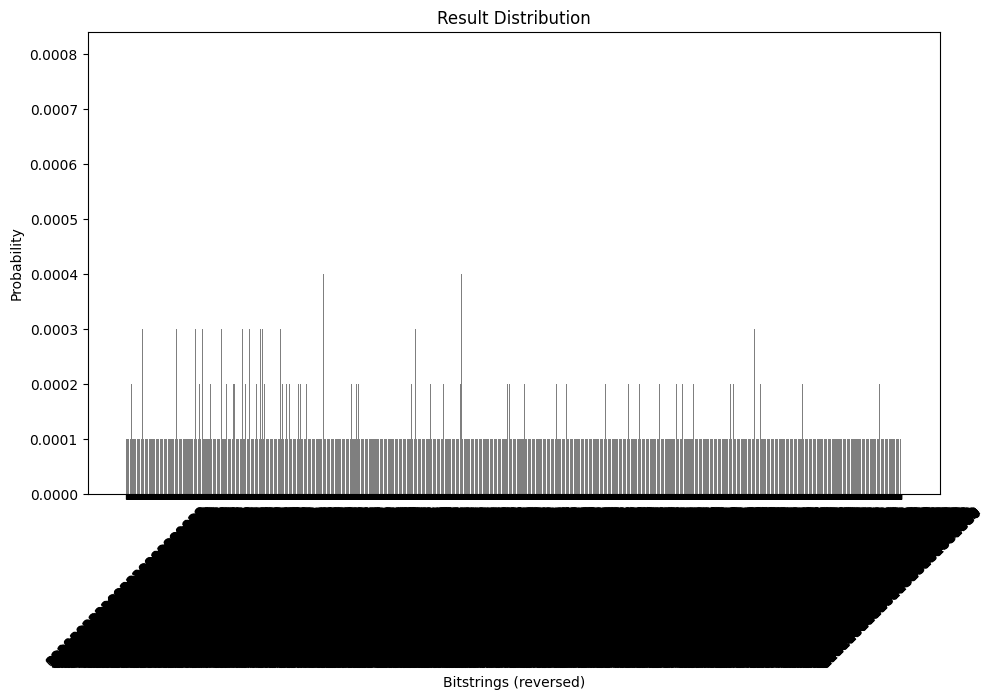

In [25]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
print(values)
top_4_values = sorted(values, reverse=True)[:4]
print(top_4_values)
positions = []

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

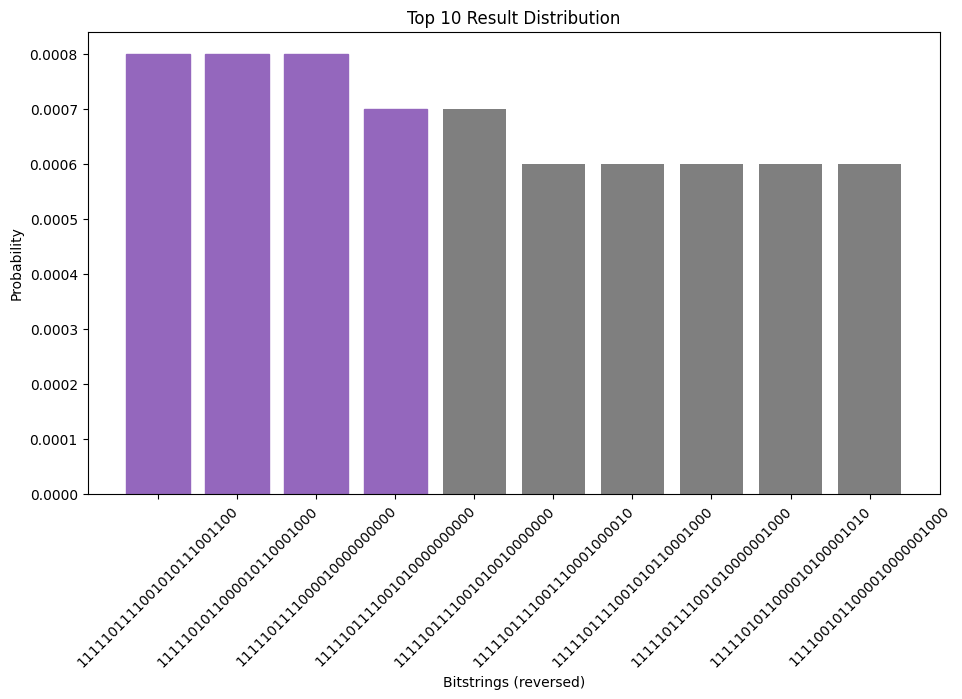

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_bits is a dictionary of bitstrings and their probabilities
final_bits = final_distribution_bin  # Replace this with your actual data

# Get the top 10 bitstrings by probability
sorted_bits = sorted(final_bits.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_keys = [k for k, _ in sorted_bits]
top_10_values = [v for _, v in sorted_bits]

# Get the indices of the top 4 probabilities
top_4_indices = sorted(range(len(top_10_values)), key=lambda i: top_10_values[i], reverse=True)[:4]

# Create the plot
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(rotation=45)
plt.title("Top 10 Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

# Bar plot for top 10 probabilities
bars = ax.bar(top_10_keys, top_10_values, color="tab:grey")

# Highlight the top 4 bars in purple
for i in top_4_indices:
    bars[i].set_color("tab:purple")

plt.show()
